# A1 Data Curation

This notebook covers the acquisition, processing, graphic analysis, and dataset publishing of Wikipedia site traffic. The goal is that this work follows best practices of open scientific reasearch to be fully reproducible and well-documented. Others should be able to follow, and expand upon this work easily.

## Initialization

This code brings in the library dependencies to be used by subsequent code.


In [344]:
import json                       # For API response handling
import requests                   # For API call handling
import pandas                     # For dataframes
import matplotlib.pyplot as plt   # For plotting

## Data acquisition

Using Wikimedia's RESTful APIs, we can obtain site traffic data. The [Pagecounts](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) API was originally provided from years 2008 to 2016, while the [Pageviews](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) API superceded it starting in 2015 to today. To produce site data from 2008 to the latest available information in 2018, the data returned from both APIs will be combined.

First, define the endpoint paths to both APIs:

In [345]:
pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/\
{granularity}/{start}/{end}'

pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/\
{granularity}/{start}/{end}'

Define personal information headers:

In [346]:
headers = {'User-Agent' : 'https://github.com/PK#ing70',
           'From'       : 'PKing70@uw.edu'
          }

Define the parameters for pagecounts, call the API, and store the JSON response:

In [347]:
params_pagecounts = {'project'     : 'en.wikipedia.org',
                     'access-site' : 'desktop-site',
                     'granularity' : 'monthly',
                     'start'       : '2001010100',
                     'end'         : '2016073100' # Pagecounts returns data until the end of July, 2016
                    }

call_pagecounts_d = requests.get(pagecounts.format(**params_pagecounts), headers = headers)
response_pagecounts_d = call_pagecounts_d.json()  # Desktop-site data

params_pagecounts["access-site"] = "mobile-site"
call_pagecounts_m = requests.get(pagecounts.format(**params_pagecounts), headers = headers)
response_pagecounts_m = call_pagecounts_m.json()  # Mobile-site data

Define the parameters for Pageviews, call the API, and store the JSON responses.

In [348]:
params_pageviews =  {"project"     : "en.wikipedia.org",
                     "access"      : "desktop",
                     "agent"       : "user",
                     "granularity" : "monthly",
                     "start"       : "2001010100",
                     "end"         : "2018101800" # Pagecounts returns data until today
                    }

call_pageviews_d = requests.get(pageviews.format(**params_pageviews), headers = headers)
response_pageviews_d = call_pageviews_d.json()    # Desktop data

params_pageviews["access"] = "mobile-app"
call_pageviews_ma = requests.get(pageviews.format(**params_pageviews), headers = headers)
response_pageviews_ma = call_pageviews_ma.json()  # Mobile app data

params_pageviews["access"] = "mobile-web"
call_pageviews_mw = requests.get(pageviews.format(**params_pageviews), headers = headers)
response_pageviews_mw = call_pageviews_mw.json()  # Mobile web browser data

Store the raw results of each API call into a separate file:

In [349]:
filename = 'pagecounts_desktop-site_200807-201607.json' # Desktop Pagecount JSON file
with open(filename, 'w') as file:
    json.dump(response_pagecounts_d, file)
    
filename = 'pagecounts_mobile-site_200807-201607.json' # Mobile Pagecount JSON file
with open(filename, 'w') as file:
    json.dump(response_pagecounts_m, file)
    
filename = 'pageviews_desktop_200807-201809.json'  # Desktop Pageview JSON file
with open(filename, 'w') as file:
    json.dump(response_pageviews_d, file)

filename = 'pageviews_mobile-app_200807-201809.json' # Mobile App Pageview JSON file
with open(filename, 'w') as file:
    json.dump(response_pageviews_ma, file)

filename = 'pageviews_mobile-web_200807-201809.json' # Mobile Web Pagecount JSON file
with open(filename, 'w') as file:
    json.dump(response_pageviews_mw, file)

## Data Processing

Combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month:

In [350]:
data_pagecounts_d = pandas.DataFrame.from_dict(response_pagecounts_d['items']) # DF for Desktop Pagecount
data_pagecounts_d['timestamp'] = data_pagecounts_d.timestamp.str[0:6] # Extract year and month from timestamp
data_pagecounts_d.rename(columns={'count': 'pagecount_desktop_views'}, inplace=True) # Use final column name

data_pagecounts_m = pandas.DataFrame.from_dict(response_pagecounts_m['items']) # DF for Mobile Pagecount
data_pagecounts_m['timestamp'] = data_pagecounts_m.timestamp.str[0:6] # Extract year and month from timestamp
data_pagecounts_m.rename(columns={'count': 'pagecount_mobile_views'}, inplace=True) # Use final column name

data_pageviews_d = pandas.DataFrame.from_dict(response_pageviews_d['items']) # DF for Desktop Pageview
data_pageviews_d['timestamp'] = data_pageviews_d.timestamp.str[0:6]   # Extract year and month from timestamp
data_pageviews_d.rename(columns={'views': 'pageview_desktop_views'}, inplace=True) # Use final column name

data_pageviews_ma = pandas.DataFrame.from_dict(response_pageviews_ma['items']) # DF for Mobile App Pageview
data_pageviews_ma['timestamp'] = data_pageviews_ma.timestamp.str[0:6] # Extract year and month from timestamp
data_pageviews_ma.rename(columns={'views': 'pageview_mobile-app_views'}, inplace=True) # Use final column name

data_pageviews_mw = pandas.DataFrame.from_dict(response_pageviews_mw['items']) # DF for Mobile Web Pagecount
data_pageviews_mw['timestamp'] = data_pageviews_mw.timestamp.str[0:6] # Extract year and month from timestamp
data_pageviews_mw.rename(columns={'views': 'pageview_mobile-web_views'}, inplace=True) # Use final column name

Merge the separate, API response-specific dataframes into one, aligned upon timestamp:

In [351]:
data_f = data_pagecounts_d[['timestamp','pagecount_desktop_views']]
data_f = data_f.merge(data_pagecounts_m[['timestamp','pagecount_mobile_views']], how='outer', on='timestamp')
data_f = data_f.merge(data_pageviews_d[['timestamp','pageview_desktop_views']], how='outer', on='timestamp')
data_f = data_f.merge(data_pageviews_ma[['timestamp','pageview_mobile-app_views']], how='outer', on='timestamp')
data_f = data_f.merge(data_pageviews_mw[['timestamp','pageview_mobile-web_views']], how='outer', on='timestamp')
#data_f

Combine all data into a single CSV file with the following headers:

|Column|Value|
|---|---|
|year|YYYY|
|month|MM|
|pagecount_all_views|num_views|
|pagecount_desktop_views|num_views|
|pagecount_mobile_views|num_views|
|pageview_all_views|num_views|
|pageview_desktop_views|num_views|
|pageview_mobile_views|num_views|

In [352]:
data_f_output = pandas.DataFrame({'year':data_f['timestamp'].str[0:4],  # First four char are the year
                                  'month':data_f['timestamp'].str[4:6], # Next two are the month
                                  'pagecount_all_views':data_f['pagecount_desktop_views']+data_f['pagecount_mobile_views'],
                                  'pagecount_desktop_views':data_f['pagecount_desktop_views'], 
                                  'pagecount_mobile_views':data_f['pagecount_mobile_views'],
                                  'pageview_all_views':data_f['pageview_desktop_views']+data_f['pageview_mobile-app_views']+\
                                      data_f['pageview_mobile-web_views'],
                                  'pageview_desktop_views':data_f['pageview_desktop_views'],
                                  'pageview_mobile_views':data_f['pageview_mobile-app_views']+\
                                      data_f['pageview_mobile-web_views']})

Re-order the columns as specified:

In [353]:
data_f_output = data_f_output[['year',
                               'month',
                               'pagecount_all_views',
                               'pagecount_desktop_views',
                               'pagecount_mobile_views',
                               'pageview_all_views',
                               'pageview_desktop_views',
                               'pageview_mobile_views']]

Save to a CSV using the specified filename:

In [354]:
filename = 'en-wikipedia_traffic_200712-201809.csv'
data_f_output.to_csv(filename, index=False, )  # Make sure the file is closed if it exists or this won't work

## Data analysis

We will make a time-series plot of the site traffic data, showing mobile, desktop, and all (combined) data.

First, extract dates from our specially formatted year and month columns:

In [355]:
dates = pandas.to_datetime(data_f_output['year'].astype(str)+data_f_output['month'].astype(str), format='%Y%m')

Next, construct the plot using matplotlib.pyplot.

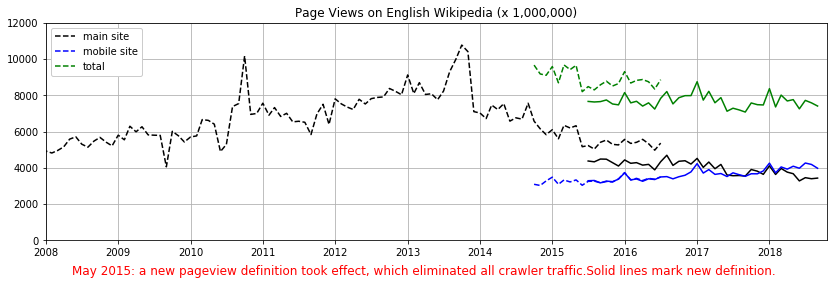

In [356]:
plt.rcParams["figure.figsize"] = (14, 4)

# Mimic the style and labels from the target image 
# https://wiki.communitydata.cc/File:En-wikipedia_traffic_200801-201709_thompson.png
plt.grid(True)
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.suptitle('May 2015: a new pageview definition took effect, which eliminated all crawler traffic.'\
             +'Solid lines mark new definition.', y=0.04, color='red');

plt.plot(dates, data_f_output['pagecount_desktop_views']/1e6, 'k--') # Divide these by 1e6 to faux-convert to Integer data
plt.plot(dates, data_f_output['pagecount_mobile_views']/1e6, 'b--')
plt.plot(dates, data_f_output['pagecount_all_views']/1e6, 'g--')

plt.plot(dates, data_f_output['pageview_desktop_views']/1e6, 'k-')
plt.plot(dates, data_f_output['pageview_mobile_views']/1e6, 'b-')
plt.plot(dates, data_f_output['pageview_all_views']/1e6, 'g-')

plt.ylim((0,12000))
plt.xlim(('2008-01-01','2018-10-18'))

plt.legend(['main site','mobile site','total'], loc=2, framealpha=1)
